In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
elabs_df = pd.read_csv("../data/hmong/extracted_elabs/elabs_extracted.csv")

B_words = Counter(elabs_df['word2'])
C_words = Counter(elabs_df['word4'])
B_C_counts = {}
for B, count in B_words.items():
    B_C_counts[B] = (count, C_words.get(B, 0))
for C, count in C_words.items():
    B_C_counts[C] = (B_words.get(C, 0), count)


In [3]:
B_C_counts

{'ub': (155, 0),
 'ntsej': (31, 0),
 'phem': (24, 13),
 'neej': (66, 0),
 'nom': (73, 1),
 'tsav': (3, 44),
 'pab': (41, 16),
 'hnub': (30, 1),
 'txeeb': (5, 3),
 'ntaub': (25, 0),
 'kev': (26, 10),
 'plaub': (19, 0),
 'ploj': (12, 0),
 'tshoob': (28, 1),
 'mis': (2, 0),
 'kwv': (66, 1),
 'dlaab': (4, 0),
 'dag': (18, 0),
 'dab': (32, 8),
 'luaj': (3, 2),
 'tub': (43, 0),
 'mab': (22, 0),
 'noj': (103, 3),
 'vaj': (60, 0),
 'thuv': (4, 8),
 'ncaj': (17, 3),
 'kab': (16, 0),
 'chawj': (3, 0),
 'zej': (52, 0),
 'hlob': (8, 0),
 'yeej': (8, 0),
 'luj': (6, 0),
 'cem': (9, 4),
 'niam': (62, 0),
 'txawj': (23, 0),
 'paub': (19, 14),
 'poj': (24, 0),
 'tooj': (16, 0),
 'nkauj': (8, 1),
 'pawg': (1, 40),
 'ntuj': (33, 0),
 'tij': (4, 66),
 'qaib': (11, 0),
 'siab': (62, 6),
 'teb': (85, 46),
 'dej': (30, 0),
 'dub': (14, 6),
 'nyiaj': (43, 0),
 'dog': (8, 0),
 'leej': (21, 0),
 'cav': (7, 1),
 'nrauj': (6, 0),
 'qub': (2, 0),
 'zoo': (16, 35),
 'liaj': (18, 0),
 'phooj': (18, 0),
 'phaib': (1

Total occurrences. This is the number of elaborate expressions * 2

In [4]:
sum(sum(bc) for bc in B_C_counts.values())

6506

If we always predicted the majority class for each word, what would be the accuracy?

In [5]:
sum(max(bc) for bc in B_C_counts.values())

6092

In [6]:
sum(max(bc) for bc in B_C_counts.values()) / sum(sum(bc) for bc in B_C_counts.values())

0.9363664309867814

The actual accuracy is even higher than this. So it means the model not only learns whether a word is majority B or majority C, but also learns the interaction between two words

## Load WV

In [7]:
import sys
sys.path.append('..')
from libraries.elab_data import HmongWordVectorsData

In [8]:
wv_trained = HmongWordVectorsData("grpdlid3_cnn_run1")
wv_sg = HmongWordVectorsData("sg")
# wv = HmongWordVectorsData("pCC1_nochar_run1")

INFO:gensim.utils:loading Word2Vec object from ../data/hmong/sch.sg.w2v
INFO:gensim.utils:loading wv recursively from ../data/hmong/sch.sg.w2v.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': '../data/hmong/sch.sg.w2v', 'datetime': '2022-01-07T14:02:19.372092', 'gensim': '4.0.1', 'python': '3.8.2 (default, May  7 2020, 20:00:49) \n[GCC 7.3.0]', 'platform': 'Linux-5.11.0-43-generic-x86_64-with-glibc2.10', 'event': 'loaded'}


detected 'lid' in model name, so using data_lid.pth
loaded word vectors from grpdlid3_cnn_run1 on patient


## Fancy scatter pie chart!

In [9]:
def draw_pie(dist, xpos, ypos, size, ax=None, figsize=(10, 8), colors=('aqua', 'gold')):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()
    for r1, r2, c in zip(pie[:-1], pie[1:], colors):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])

        ax.scatter([xpos], [ypos], marker=xy, s=size, facecolor=c)

    return ax

In [10]:
!pip install umap-learn

In [11]:
from sklearn.manifold import TSNE
from umap import UMAP
proj_method = 'UMAP'

In [12]:
hmong_words = list(B_C_counts.keys())


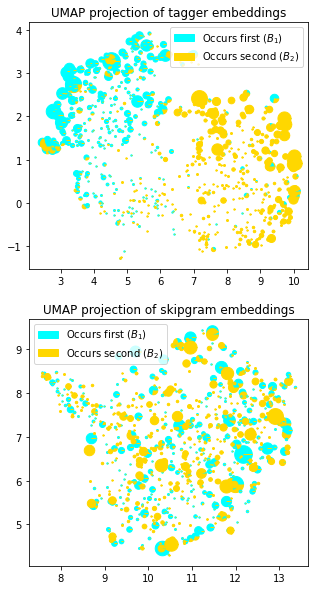

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

for ax, wv, name in zip(axs, (wv_trained, wv_sg), ('tagger', 'skipgram')):
    X = np.concatenate([wv[word][None, :] for word in hmong_words], axis=0)

    if proj_method == 'TSNE':
        projector = TSNE(perplexity=30, random_state=2)
    elif proj_method == 'UMAP':
        projector = UMAP()

    X_proj = projector.fit_transform(X)

    color1 = 'aqua'
    color2 = 'gold'

    for i, word in enumerate(hmong_words):
        counts = B_C_counts[word]
        xpos, ypos = X_proj[i]
        size = sum(counts)*2
        draw_pie(counts, xpos, ypos, size, ax=ax, colors=(color1, color2))

    #     if size > 60:
    #         ax.annotate(word, (X_proj[i][0], X_proj[i][1]))  

    patch1 = mpatches.Patch(color=color1, label='Occurs first ($B_1$)')
    patch2 = mpatches.Patch(color=color2, label='Occurs second ($B_2$)')

    ax.legend(handles=[patch1, patch2])

    ax.set_title(f"{proj_method} projection of {name} embeddings")  
#     plt.show()

plt.savefig("umap_1.eps")

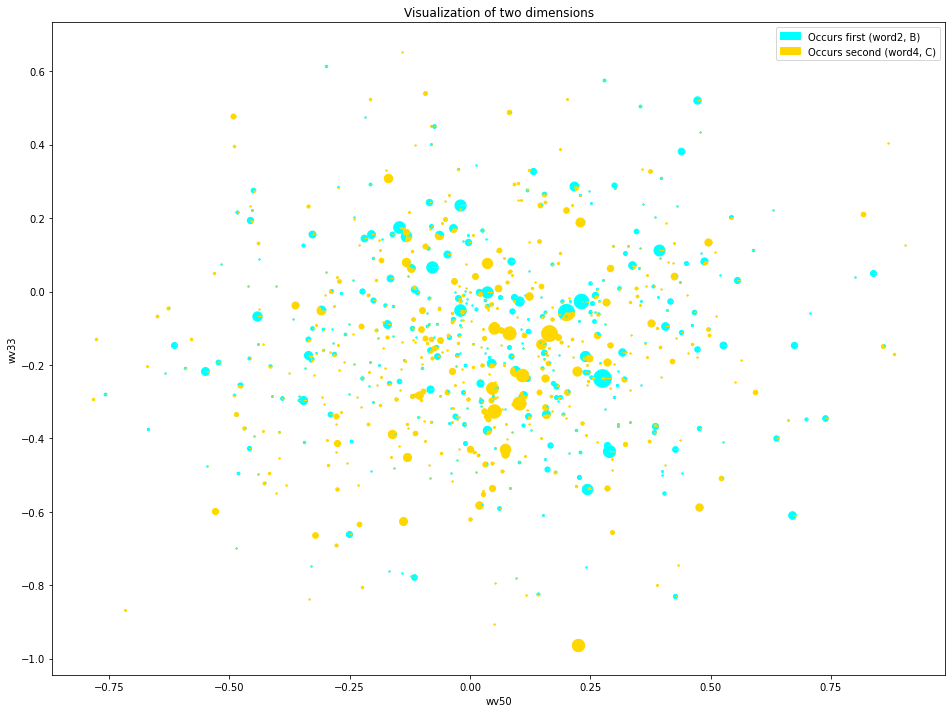

In [13]:
# fig, ax = plt.subplots(figsize=(16, 12))
# for i, word in enumerate(hmong_words):
#     counts = B_C_counts[word]
#     xpos, ypos = X[i, 50], X[i, 33]
#     size = sum(counts)*2
#     draw_pie(counts, xpos, ypos, size, ax=ax)
    
# #     if size > 60:
# #         ax.annotate(word, (X_proj[i][0], X_proj[i][1]))  

# aqua_patch = mpatches.Patch(color='aqua', label='Occurs first (word2, B)')
# gold_patch = mpatches.Patch(color='gold', label='Occurs second (word4, C)')

# ax.legend(handles=[aqua_patch, gold_patch])

# plt.xlabel("wv50")
# plt.ylabel("wv33")
# plt.title("Visualization of two dimensions")  
# plt.show()